# Inference in a neural emulation model



Look, we can do approximate probabilistic inference with a complicated neural network! Here we will use a 2-million parameter neural net to generate a an approximate likelihood for inference in a model.



## Set up

In [14]:
import numpy as np
from math import sqrt, ceil, floor

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.functional import F 

from src.graphs import fno_graph
from src.plots import img_plot, multi_img_plot_batch, multi_img_plot_time, multi_heatmap

# device = torch.device('cuda')  # I can't make MCMC work on the GPU 😢
device = torch.device('cpu')

## The data

We have a dataset of snapshots from a [Navier-Stokes](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) simulator.

This dataset is packed as as $(b, x, y, t)$ i.e. batch first, coordinates in the middle, time last. 

In [15]:
data = np.load('./data/grf_forcing_single.npz')

def get_obs(data, t=0, n_steps=2, y=False):
    """
    helper function to parse the data into cunks with teh correct size and names for the model
    """
    x = data['u'][..., t:t+n_steps]
    latent = data['f'][...]
    obs= {
        'x': x,
        'latent': latent
    }
    if y:
        obs['y'] = data['u'][..., t+n_steps]

    return obs

def dict_as_tensor(d, device=device):
    """
    Send a dict of arrays to pytorch tensors.
    it was faster to write this function than to search the docs for it
    """
    return {k: torch.as_tensor(v).to(device) for k, v in d.items()}

## Visualise the data

First we look at the snapshots of the simulation. First the vorticity field $x(t)$:

range(0, 19, 5) 4 4


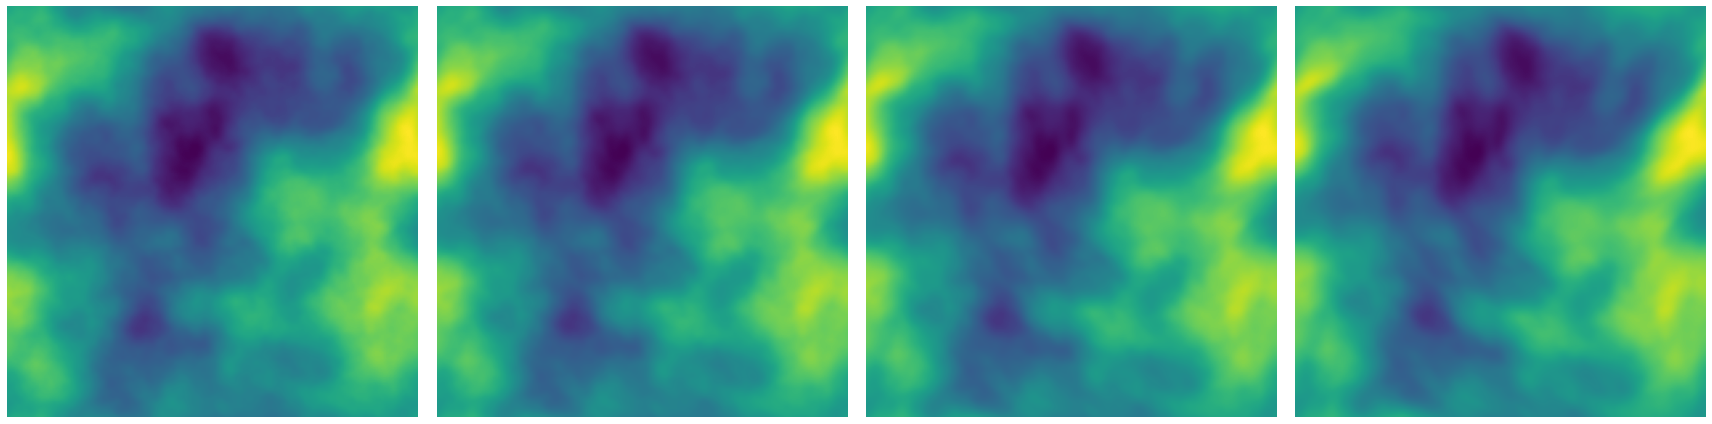

In [16]:
multi_img_plot_time(get_obs(data, 0, -1)['x'], n_cols=4, interval=5);

Next we look at the _latent forcing_, which is a time-invariant field that perturbs the dynamics of $x$

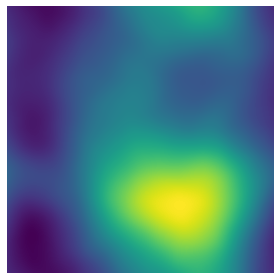

In [17]:
img_plot(get_obs(data, 0, -1)['latent']);

## Process predictor model

Running a PDE simulator is expensive, so have trained a neural network which can hopefully reproduce these observations, by giving it a data set of 1000 simulations made up of many snapshots. The details of the network are on [Zongyi Li’s blog](https://zongyi-li.github.io/blog/2020/fourier-pde/).

NB the data we have here is from the validation set — the neural network has not seen this data during the training phase.

In [18]:
from src.nn_modules.fourier_2d_generic import SimpleBlock2dGeneric

pp_state_dict = torch.load(
    './models/fno_forward.ckpt',
    map_location=device
)
process_predictor = SimpleBlock2dGeneric(
    modes1=16,
    width=24,
    n_layers=4,
    n_history=2,
    param=False,
    forcing=False,
    latent=True,
)
process_predictor.load_state_dict(
    pp_state_dict
)

<All keys matched successfully>

The model maps the vorticity field $x$ at two previous timesteps and the latent forcing field to the vorticity field at the next timestep.
We think of the neural network weights $\theta$ as (some approximation to) the parameters of the model, and we learn them by minimising some predictive error.



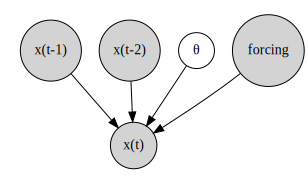

In [19]:
fno_graph(obs="fwd")

We can repeatedly invoke this to push the model forward in time

range(0, 50, 5) 10 5


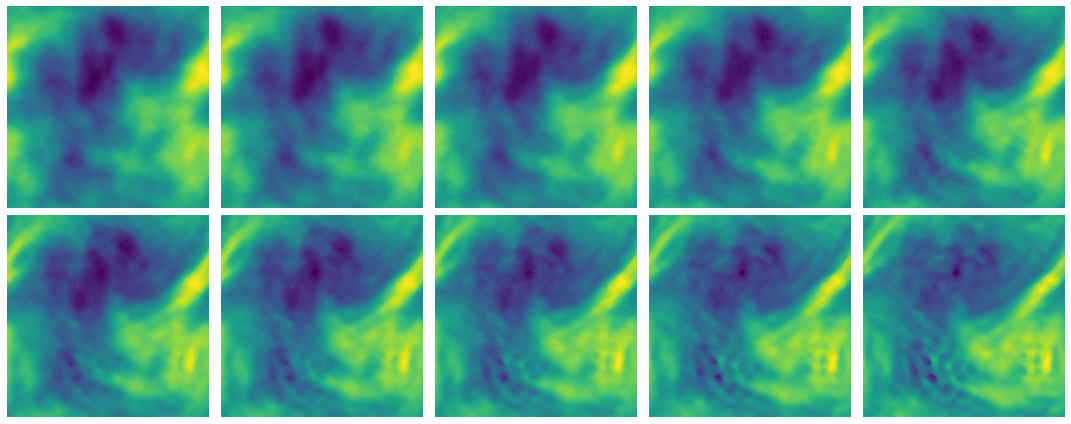

In [20]:
def predict_forward(x, latent, n_horizon=1, n_steps=2):
    x = torch.as_tensor(x).to(device)
    latent = torch.as_tensor(latent).to(device)
    process_predictor.to(device)
    for i in range(n_horizon):
        pred = process_predictor({'x': x[...,-(n_steps):], 'latent': latent})['forecast']
        x = torch.cat((x, pred), dim=-1)
    return x[...,-n_horizon:]

obs = get_obs(data, 0, 10,)

with torch.no_grad():
    pred = predict_forward(obs['x'], obs['latent'], n_horizon=50, n_steps=2)

multi_img_plot_time(pred.cpu().numpy(), n_cols=5, interval=5);
## How the teaser graphic in the README was generated:
# plt.savefig('./fno_forward_predict_sheet.jpg');

DISCLAIMER: This is _not_ the most finely tuned of this model — in fact it is one with relatively low accuracy because that makes the statistical difficulties of inference easier to see with the naked eye.

## Inversion by GD

Now we want to solve an inverse problem with this model: given some observations of $x(t), x(t-1), x(t-2)$, what is the best guess for the latent forcing field?


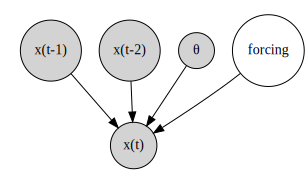

In [21]:
fno_graph(obs="inverse")

We can in fact predict and do inversion through the PDE equations directly, but this is _slow_ (hours), so we use the neural network to solve this problem directly.
Firstly, we can do this directly as pure predictive error minimisation problem. Forget the probabilistic interpretation of this problem and just minimise some loss function. 

In [22]:
class RasterLatent(nn.Module):
    def __init__(self,
            process_predictor: "nn.Module",
            dims = (256,256),
            latent_dims = None,
            interpolation = 'bilinear',
            n_batch: int=1):
        super().__init__()
        self.dims = dims
        if latent_dims is None:
            latent_dims = dims
        self.latent_dims = latent_dims
        self.interpolation = interpolation
        self.process_predictor = process_predictor
        ## Do not fit the process predictor weights
        process_predictor.train(False)
        for param in self.process_predictor.parameters():
            param.requires_grad = False
            
        self.latent = nn.Parameter(
            torch.zeros(
                (n_batch, *latent_dims),
                dtype=torch.float32
            )
        )
    
    def get_latent(self):
        if self.latent_dims==self.dims:
            return self.latent
        return F.interpolate(
            self.latent.unsqueeze(1),
            self.dims,
            mode=self.interpolation
        ).squeeze(1)  #squeeze/unsqueeze is because of weird interpolate semantics

    def weights_init(self, scale=0.005):
        self.latent.data.normal_(0.0, scale)

    def forward(self, batch):
        batch = dict(**batch)
        batch['latent'] = self.get_latent()
        return self.process_predictor(batch)

In [23]:
def fit(
        batch,
        model,
        optimizer,
        n_iter: int=20,
        check_int: int=1,
        clip_val = None,
        init_scale=0.1):
    model.train()
    model.to(device)
    model.weights_init(init_scale)
    loss_fn = nn.MSELoss()
    big_loss_fn = nn.MSELoss(reduction='none')
    scale = loss_fn(torch.zeros_like(batch['latent']), batch['latent']).item()
    for i in range(n_iter):
        # Compute prediction error
        pred = model(batch)
        loss = loss_fn(pred['forecast'], batch['y'])
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        if clip_val is not None:
            for group in optimizer.param_groups:
                torch.nn.utils.clip_grad_value_(group["params"], clip_val)

        optimizer.step()

        if i % check_int == 0 or i==n_iter-1:
            with torch.no_grad():
                loss_v = loss.item()
                # batchwise error
                big_error = big_loss_fn(model.get_latent(), batch['latent']).mean(dim=(1,2))
                big_relerr = torch.sqrt(big_error/scale)
                error = big_error.mean().item()
                relerr = sqrt(big_relerr.mean().item())
                print(
                    f"loss: {loss:.3e}, error: {error:.3e}, relerror: {relerr:.3e} [{i:>5d}/{n_iter:>5d}]")

                target =  batch['latent'][0, :, :].cpu().numpy()
                est =  model.get_latent()[0, :, :].cpu().numpy()
                err_heatmap = target - est
                multi_heatmap(
                    [target, est, err_heatmap],
                    ["Target", "Estimate", "Error"])
                plt.show();
                plt.close("all");

    return loss_v, error, relerr, scale


/scratch2/mac581/hackfest-ppl/venv/lib64/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/scratch2/mac581/hackfest-ppl/venv/lib64/python3.6/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 256, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 9.697e-02, error: 1.727e-04, relerror: 1.041e+00 [    0/   50]


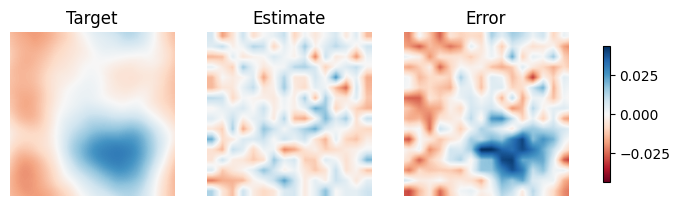

loss: 9.591e-02, error: 6.298e-04, relerror: 1.439e+00 [   10/   50]


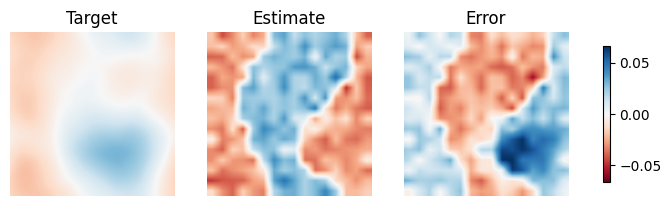

loss: 9.487e-02, error: 2.187e-03, relerror: 1.964e+00 [   20/   50]


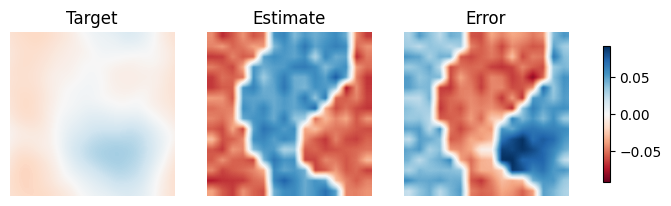

loss: 9.385e-02, error: 4.825e-03, relerror: 2.394e+00 [   30/   50]


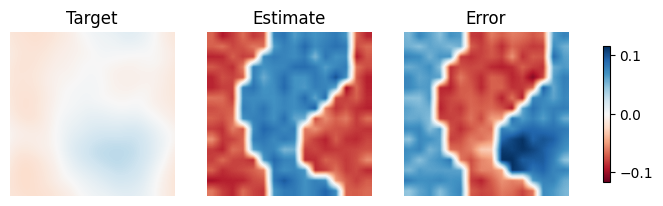

loss: 9.285e-02, error: 8.515e-03, relerror: 2.759e+00 [   40/   50]


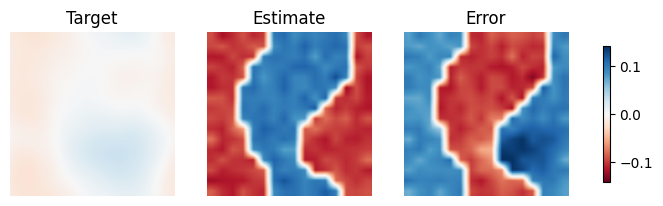

loss: 9.198e-02, error: 1.271e-02, relerror: 3.049e+00 [   49/   50]


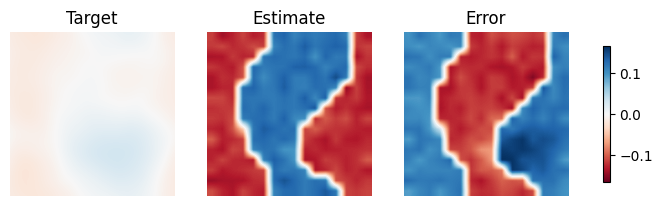

(0.09198091924190521,
 0.012706989422440529,
 3.049466952661323,
 0.00014694234414491802)

In [24]:
model = RasterLatent(
    process_predictor,
    dims=obs['x'].shape[1:3],
    latent_dims=(16,16),
    n_batch=1)
optimizer = AdamW(
    model.parameters(),
    lr=0.0025,
    weight_decay=0.0)

loss_fn = nn.MSELoss()

fit(
    dict_as_tensor(get_obs(data,t=10,n_steps=2,y=True)),
    model,
    optimizer,
    n_iter=50,
    check_int=10,
    clip_val=None,
    init_scale=0.01
)

## Probabilistic version

Here is a selling point of pyro: we can use plain old pytorch neural nets inside pyro inference at it works fine.

Documentation for this feature:

* [Modules in Pyro — Pyro Tutorials](https://pyro.ai/examples/modules.html)
* [Neural Networks — Pyro documentation](https://docs.pyro.ai/en/stable/nn.html#pyro.nn.module.PyroSample)


Let us call the forward operator neural network the _FNO_.
We will for the sake of argument, assume it is a good predictor of the expected value of the next timestep from the previous timesteps and latents.
We write up an approximate model where the latent field and the forcing field are both perturbed by independent Gaussian noises.

$$\begin{aligned}
x(t)(i,j) &\sim \mathcal{N}(\mu(i,j),0.01\\
\mu(i,j) &= \operatorname{FNO}(x(t-2), x(t-1),\operatorname{latent},{\theta})(i,j)\\
\operatorname{latent}(i,j) &\sim \mathcal{N}(0,0.1)
\end{aligned}$$

Here the $(i,j)$ notation implies a discretization of the spatial domain; we are going to evaluate this model predictions on a raster grid.
In fact, we introduced a discretization already at the neural network training stage, but we make it explicit here.

In [25]:
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
from pyro.infer import  MCMC, NUTS
from pyro import poutine


class ProbRasterLatent(PyroModule):
    def __init__(
            self,
            process_predictor: "nn.Module",
            dims = (256,256),
            latent_dims = (16,16),
            interpolation = "bilinear",
            prior_scale = 0.01,
            obs_scale = 0.01,):
        super().__init__()
        self.dims = dims
        if latent_dims is None:
            latent_dims = dims
        self.latent_dims = latent_dims
        self.interpolation = interpolation
        self.prior_scale = prior_scale
        self.obs_scale = obs_scale
        self.process_predictor = process_predictor
        process_predictor.train(False)
        ## Do not fit the process predictor weights
        for param in self.process_predictor.parameters():
            param.requires_grad = False
        self.latent = PyroSample(dist.Normal(0, 0.01).expand(latent_dims).to_event(2))

    def get_latent(self):
        if self.latent_dims==self.dims:
            return self.latent.unsqueeze(0)
        l =  F.interpolate(
            self.latent.unsqueeze(0).unsqueeze(0),
            self.dims,
            mode=self.interpolation
        ).squeeze(0) #squeeze/unsqueeze is because of weird interpolate semantics
        return l

    def forward(self, X, y=None):
        #overwrite process predictor batch with my own latent
        mean = self.process_predictor({
            'x': X,
            'latent': self.get_latent(),
        })['forecast'].squeeze(-1)
        # print("mean", mean.shape)
        o = pyro.sample(
            "obs", dist.Normal(mean, self.obs_scale).to_event(2),
            obs=y)
        # print("o", o)
        return o


In [26]:
obs = dict_as_tensor(get_obs(data, 0, 2, y=True))

model = ProbRasterLatent(
    process_predictor.to(device),
    dims=obs['x'].shape[1:3],
    prior_scale=0.01,
    obs_scale=0.01,
)
trace = poutine.trace(model).get_trace(obs['x'], obs['y'])
print(trace.format_shapes())

model.to(device)
nuts_kernel = NUTS(model, full_mass=False, max_tree_depth=5, jit_compile=True) # high performacne config

mcmc = MCMC(nuts_kernel, num_samples=20, warmup_steps=10, num_chains=1)
mcmc.run(obs['x'], obs['y'])
mc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}


Trace Shapes:            
 Param Sites:            
Sample Sites:            
  latent dist   |  16  16
        value   |  16  16
     obs dist 1 | 256 256
        value 1 | 256 256


Warmup:   0%|          | 0/30 [00:00, ?it/s]/scratch2/mac581/hackfest-ppl/venv/lib64/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/scratch2/mac581/hackfest-ppl/venv/lib64/python3.6/site-packages/einops/einops.py:179: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  axes_lengths[unknown_axis] = length // known_product
/scratch2/mac581/hackfest-ppl/operator_inversion/src/n

Note that this probabilistic model is not particularly clever. Would the latent forcing field be well-approximated by i.i.d. Gaussian noise? Probably not. But nonetheless the samples from this posterior field are not too bad.

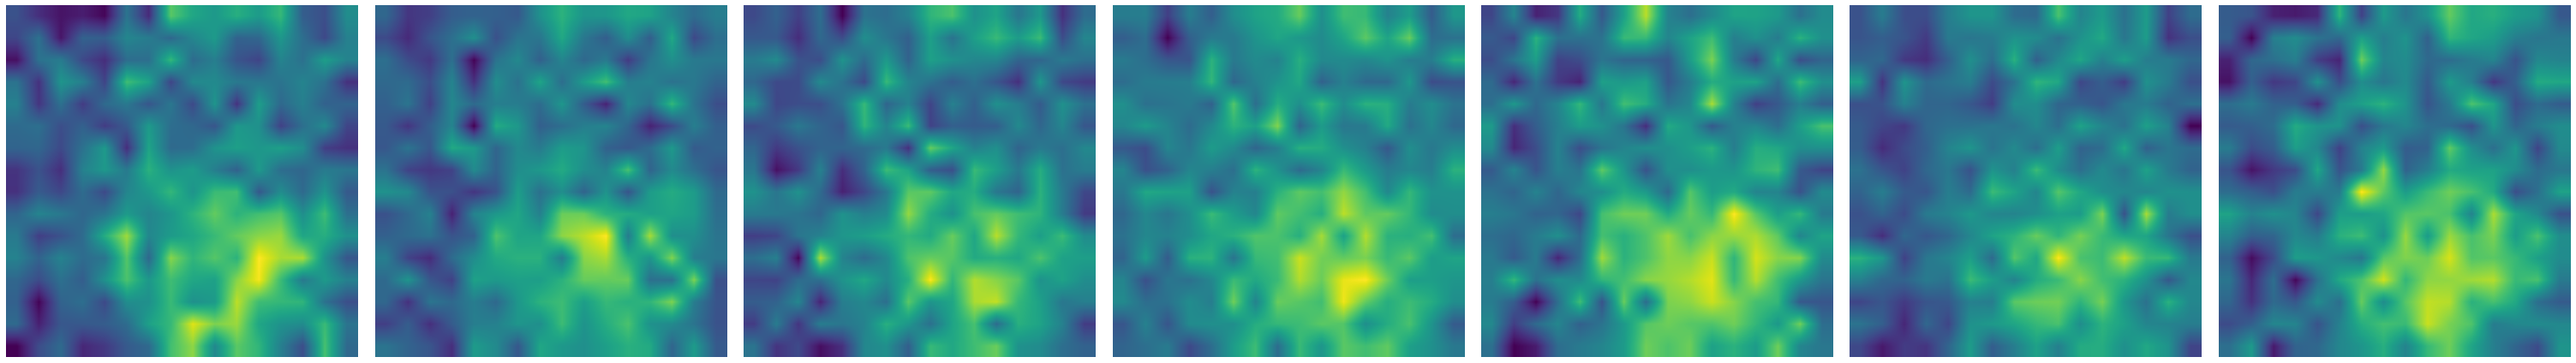

In [27]:
multi_img_plot_batch(mc_samples['latent'], interpolation="bilinear", interval=3);

If we take the (pointwise) mean over these samples, we get something that looks more like our target estimand:

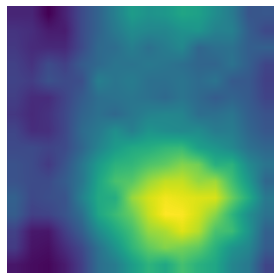

In [28]:
img_plot(mc_samples['latent'].mean(0), interpolation="bilinear");

As a reminder, this is the answer we would ideally like to recover

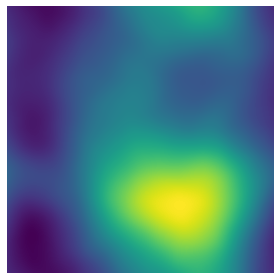

In [29]:
img_plot(get_obs(data, 0, -1)['latent']);

With a little image processing we can compare these images with that error heatmap as before

/scratch2/mac581/hackfest-ppl/venv/lib64/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


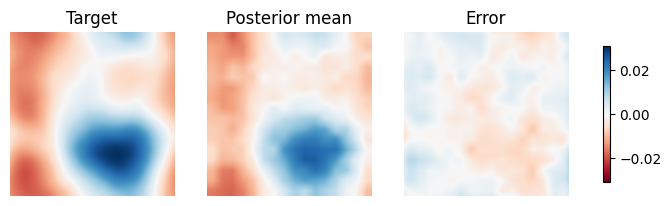

In [30]:
posterior_mean = F.interpolate(
    mcmc.get_samples()['latent'].mean(0).unsqueeze(0).unsqueeze(0),
    (256,256),
    mode='bilinear').squeeze(0).squeeze(0).detach().cpu().numpy()
target = get_obs(data, 0, -1)['latent'].squeeze(0)
err = posterior_mean - target
multi_heatmap(
    [target, posterior_mean, err],
    ["Target", "Posterior mean", "Error"])
plt.show();

We can probably do better than this.

1. HMC is a good default MCMC algorithm, but probably in this case we could try Gibbs sampling to see if it is faster.
2. uncorrelated Gaussian noise is not plausible for such a model; we could assume some correlation structure for the latent field.
3. this raster grid basis is a little silly. We have reason to suspect that a Fourier basis would be better; however, complex numbers are not well supported by pyro, so I didn't have time to implement all that we needed.